In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics_R
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data_nD
from project_utils.surroagte_gp     import Surrogate_GP



In [2]:
Num_Points    = 5
Title         = 'Synthetic Regression'
FUR_Weight    = 0.1
N_consistancy = 25
consist_bound = 0.3

In [3]:
if isinstance(FUR_Weight, float):
    FUR_Weight = [FUR_Weight, 1.0 - FUR_Weight]
    
print(FUR_Weight)

[0.1, 0.9]


In [4]:
# Load Forrester model

Reg_Data = BB_Model(dataset = 'Synthetic_Reg', Feature_Counts=[16,12])

#Reg_Data.df().head()

In [5]:
Reg_Data.MPL()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.26885088246519706


MLPRegressor(random_state=RandomState(MT19937) at 0x2200E1B9840)

In [6]:
Reg_Data.Random_Forest()

0.2978299749391252


RandomForestRegressor(random_state=RandomState(MT19937) at 0x2200E1B9840)

In [7]:
Reg_Data.GP()

-1.167354854929541


GaussianProcessRegressor()

In [8]:
Reg_Data.L_Regression()

0.2697268877233985


LinearRegression()

In [9]:
print(Reg_Data.get_features())

['Passive_0', 'Passive_1', 'Active_2', 'Active_3', 'Active_4', 'Active_5', 'Active_6', 'Active_7']


In [10]:
#Default settings
from unravel_2.ur_model import UR_Model

X_train, X_test, y_train, y_test = Reg_Data.get_TT_data()

#Initializing the explainer object
URM_Exp = UR_Model(bbox_model           = Reg_Data.get_Random_Forest(),
                   train_data           = X_train,
                   feature_names        = Reg_Data.get_features(),
                   categorical_features = Reg_Data.get_catagorical(),
                   mode                 = Reg_Data.get_mode(),
                   sampling_optimize    = "opt")

#sur_GP = Surrogate_GP()


In [11]:
#I2nd explainer object
URM_Exp_2 = UR_Model(bbox_model           = Reg_Data.get_L_Regression(),
                     train_data           = X_train,
                     feature_names        = Reg_Data.get_features(),
                     categorical_features = Reg_Data.get_catagorical(),
                     mode                 = Reg_Data.get_mode(),
                     sampling_optimize    = "opt")



In [12]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [ 16.86400721  13.35684362   7.64276393  14.41288954  12.783862
  15.6157493  -13.87447559  11.23003367]
Std 0:  [3.41776268 3.01838891 3.40979509 1.92911691 3.33959009 4.46469275
 1.95678179 4.43774821]


In [13]:
# Generate explantion data for Random Forest

Reg_Stats   = Feature_Statistics_R(feature_names = Reg_Data.get_features(),
                                   mode          = Reg_Data.get_mode(),
                                   X_train_std   = Reg_Data.get_X_train_std(),
                                   N_consistancy = N_consistancy)

Reg_Stats_2 = Feature_Statistics_R(feature_names = Reg_Data.get_features(),
                                   mode          = Reg_Data.get_mode(),
                                   X_train_std   = Reg_Data.get_X_train_std())


if Num_Points > X_test.shape[0]: Num_Points = X_test.shape[0]

elif Num_Points == 0:            Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
    data_row  = np.array([X_test[test_instance]])
    
#    data_row  = np.array([0.4])

#    print('data row ',data_row)
    
    URM_Exp.explain(X_init      = data_row.reshape(1, -1),
                    Dimension   = 'Multi D',
                    kernel_type = "Matern",
                    max_iter    = 20,
                    alpha       = "FUR_W",
                    #jitter=5,
                    interval    = 1,
                    weight      = FUR_Weight,
                    normalize   = False)
       
    f_predict = Reg_Data.get_Random_Forest().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    acq_data = URM_Exp.get_acq_data()
    
#    X, y = URM_Exp.get_surrogate_data()

#    e_predict = sur_GP.predict(X, y)
#    e_predict = sur_GP.predict(URM_Exp.get_surrogate_data())

    print(f_predict, e_predict, acq_data.get_fe_x0())
    
    scores = URM_Exp.permutation_importance()
    
    consistancy = URM_Exp.Y_Consistancy(N_points = N_consistancy, std_bound = consist_bound)
    
    URM_Exp.del_1_rel()
    
    del_1_var = URM_Exp.get_del_1_variance()
    
    Reg_Stats.Add_Sample(sample_scores = scores,
                         outcome       = y_test[test_instance],
                         X_row         = data_row.reshape(1, -1),
                         f_prediction  = f_predict,
                         e_prediction  = e_predict.ravel(),
                         feopt         = acq_data.get_fe_x0(),
                         consistancy   = consistancy,
                         del_1_var     = del_1_var)
    
    
    ############################################################################################
    
    URM_Exp_2.explain(X_init      = data_row.reshape(1, -1),
                      Dimension   = 'Multi D',
                      kernel_type = "Matern",
                      max_iter    = 20,
                      alpha       = "FUR_W",
                      #jitter=5,
                      interval    = 1,
                      weight      = FUR_Weight,
                      normalize   = False)
       
    f_predict = Reg_Data.get_L_Regression().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp_2.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    scores = URM_Exp_2.permutation_importance()
    
    Reg_Stats_2.Add_Sample(sample_scores = scores,
                           outcome       = y_test[test_instance],
                           X_row         = data_row.reshape(1, -1),
                           f_prediction  = f_predict,
                           e_prediction  = e_predict.ravel(),
                           feopt         = None)
    


INSTANCE:  0
Acq_Data_nD
[35.375433] [3.53754330e+01 1.00000004e-05] [35.375433]
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
INSTANCE:  1
Acq_Data_nD
[-61.33548637] [-6.13354864e+01  1.00000004e-05] [-61.33548637]
Acq_Data_nD
INSTANCE:  2
Acq_Data_nD
[-34.58785011] [-3.45878501e+01  1.00000004e-05] [-34.58785011]
Acq_Data_nD
INSTANCE:  3
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[-74.60447762] [-7.46044776e+01  1.00000004e-05] [-74.60447764]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  4
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[-35.88868582] [-3.58886858e+01  1.00000004e-05] [-35.88868583]
Acq_Data_nD


In [14]:
import matplotlib.pyplot as plt


In [15]:
print(f_predict)
print(e_predict)


[-38.24431575]
[-3.82443158e+01  1.00000004e-05]


In [16]:
Reg_Stats.Feature_Counts(max_features=20, scaled=True, threshold=0.05)


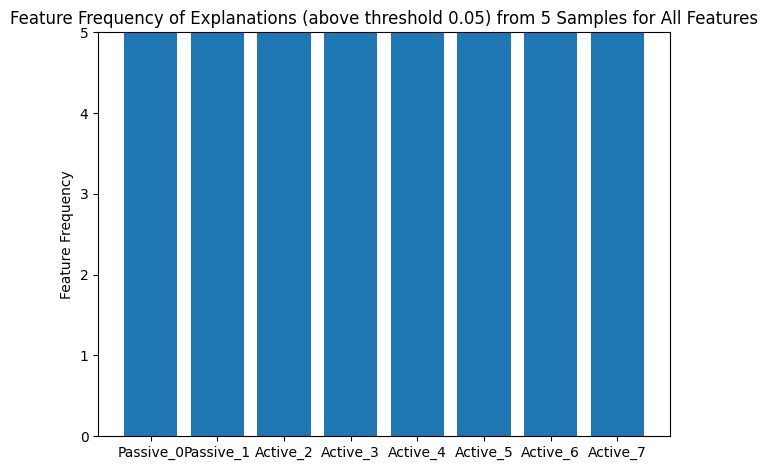

In [17]:
Reg_Stats.Frequency_Plot()


Average, SD, and Max Differences:
y - BB(x):           50.99483274247781  :  25.886260008888392  :  78.61532954272607
y - exp(x):          50.99483273692671  :  25.886260010913492  :  78.61532954294756
BB(x) - exp(x):      6.819938391799951e-09  :  6.783613470746256e-09  :  1.8961856085297768e-08
Average exp(x) Uncertainty:  1.0000000413701846e-05
R Score:   1.0
Fidelity:  0.5670597433837292


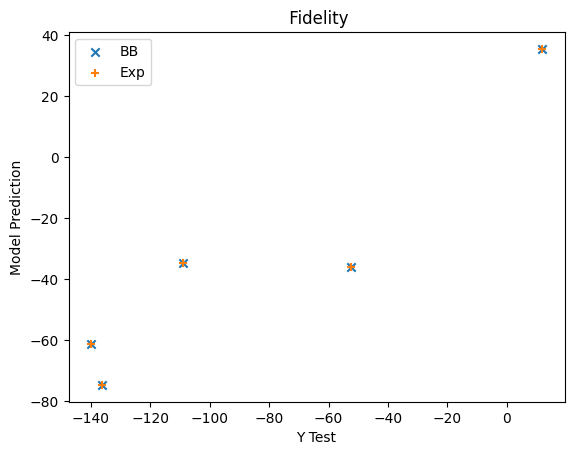

In [18]:
Reg_Stats.Fidelity()

In [19]:
Reg_Stats.Jaccard_Values()

Mean Jaccard Similarity:  0.5714285714285714
Mean Jaccard Distance:    0.42857142857142855


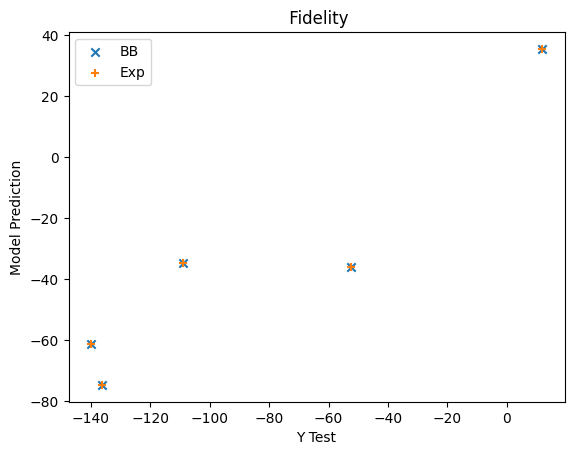

In [20]:
Reg_Stats.Reg_Fidelity_Graph()

top_features True
top_features (5, 8)


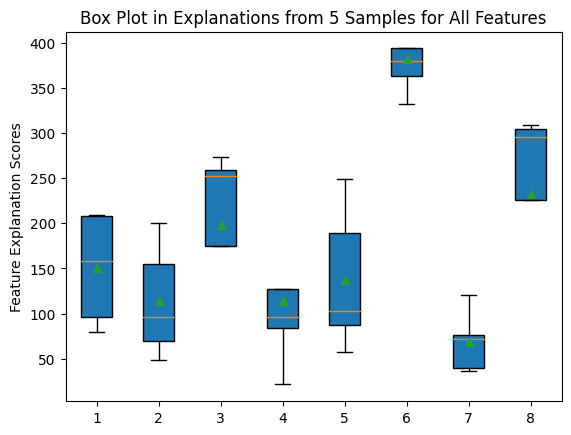

1 -      Passive_0
2 -      Passive_1
3 -      Active_2
4 -      Active_3
5 -      Active_4
6 -      Active_5
7 -      Active_6
8 -      Active_7


In [21]:
Reg_Stats.Box_Plot()


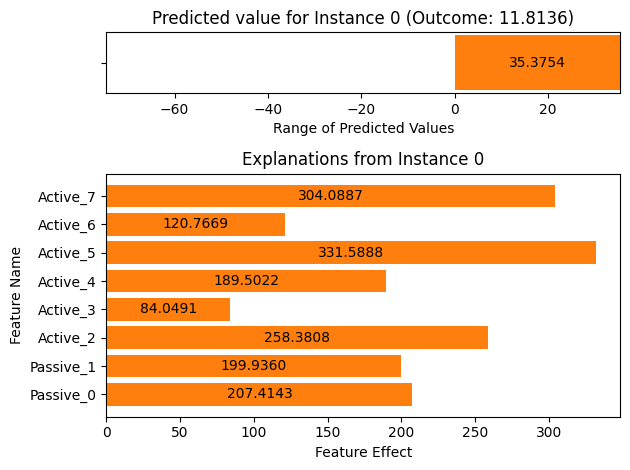

In [22]:
Reg_Stats.View_Explanation(instance = 0)

In [23]:
scores = URM_Exp.permutation_importance()
    
print(scores)

[149.17986539 152.14801956 283.83234638 134.23760847 146.27718613
 542.58385609  60.21014188 364.62060549]


In [24]:
scores_k = URM_Exp.KL_imp()

print(scores_k)

[5.13523989 4.81847168 5.22666515 6.96210086 5.01948786 6.98789287
 4.8326547  5.17342216]


In [25]:
scores_v = URM_Exp.Var_imp()

print(scores_v)

[21.94217126 12.37999298 20.92517683 39.24970601 19.12916539 39.38058441
 14.0730621  27.43400995]


In [26]:
scores_d1 = URM_Exp.del_1_rel()

print(scores_d1)

[1.18381526 1.03632013 0.60921014 1.26359884 1.1012753  1.24697091
 1.24683282 0.31197661]


In [27]:
scores_d2 = URM_Exp.del_2_rel()

print(scores_d2)

[1.8201356  0.75965632 0.06233289 1.60438925 0.69298876 2.25778043
 0.0845781  0.71813863]


In [28]:
lin_scores = URM_Exp.Lin_scores()

print(lin_scores)

[ -2.61326768   4.64926898   4.08857008 -11.6180214   -4.11283032
  11.02415633   1.38491198   2.75626619]


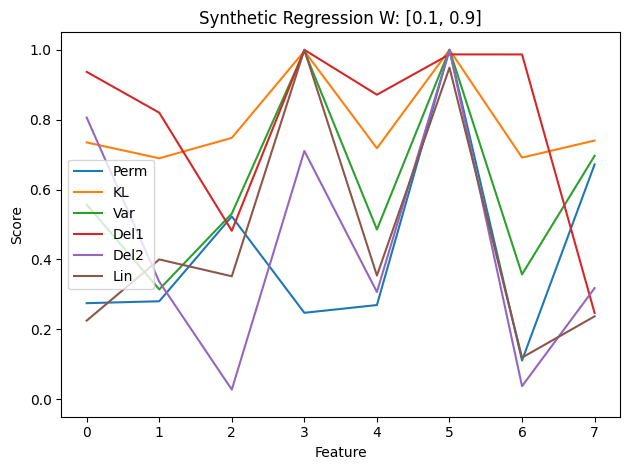

In [29]:
URM_Exp.plot_scores(Title, FUR_Weight)

In [30]:
print(URM_Exp.get_exp_L())


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.05540028e-01  8.62803152e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.59009820e-01 -1.22546848e-01  8.20055054e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.0

In [31]:
acq_data.Create_BB_plot()

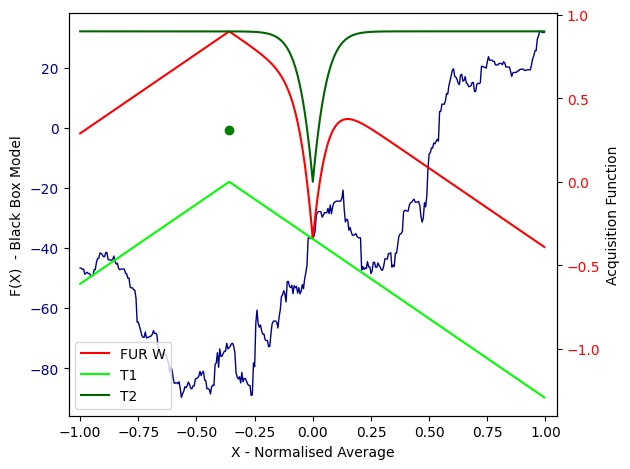

In [32]:
acq_data.plot_point(0)

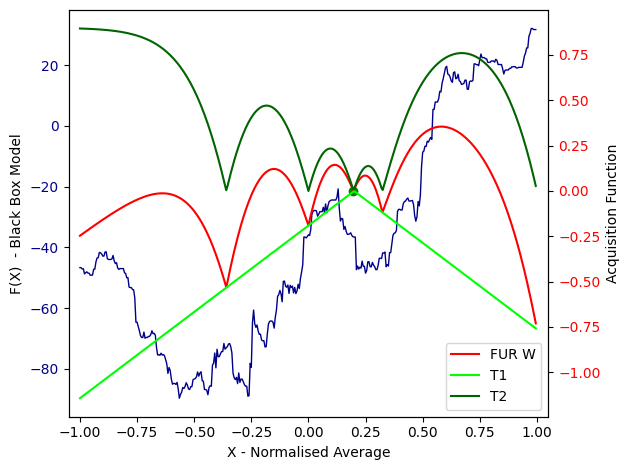

In [33]:
acq_data.plot_point(5)

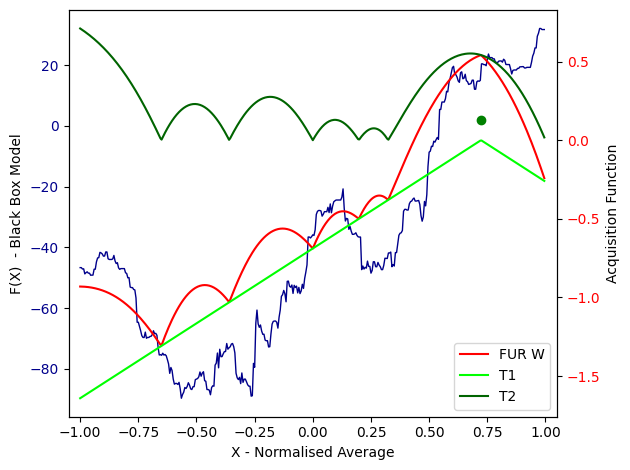

In [34]:
acq_data.plot_point(10)

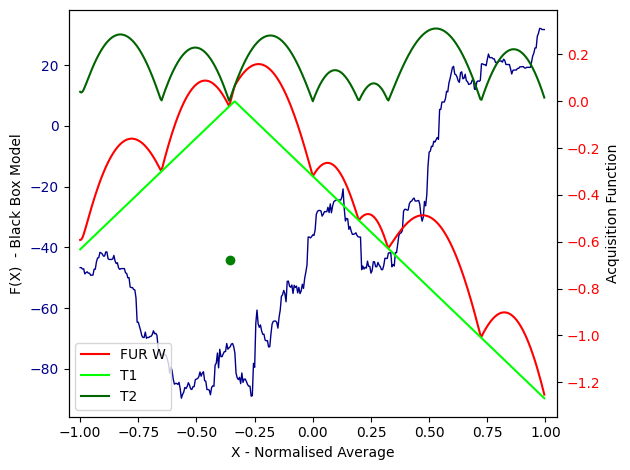

In [35]:
acq_data.plot_point(15)

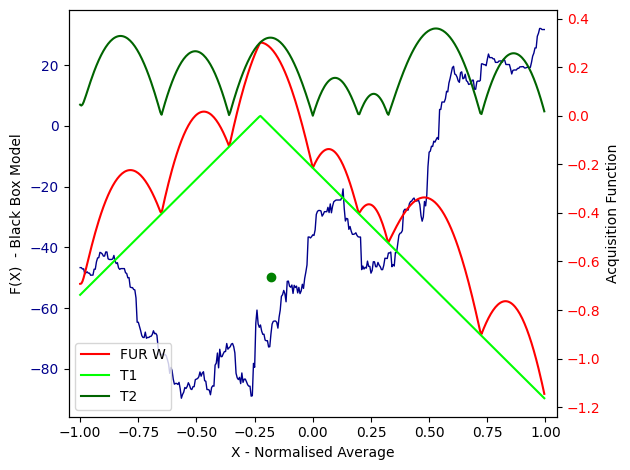

In [36]:
acq_data.plot_point(19)

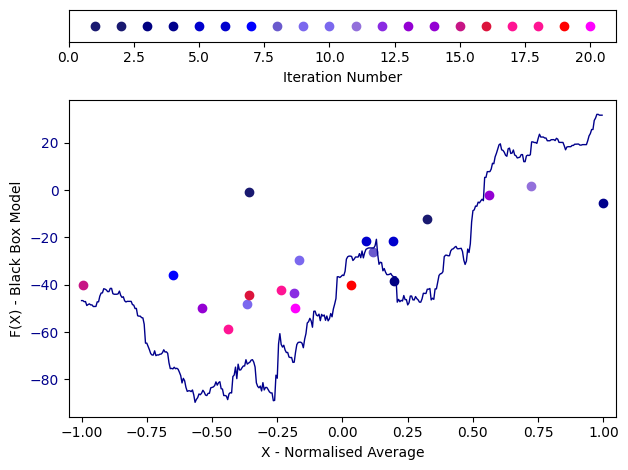

In [37]:
acq_data.plot_all()

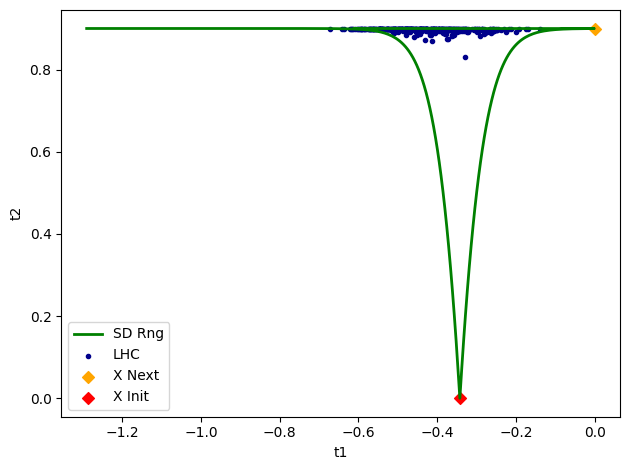

In [38]:
acq_data.plot_t1_t2(0)

In [39]:
#acq_data.plot_t1_t2(1)

In [40]:
#acq_data.plot_t1_t2(2)

In [41]:
#acq_data.plot_t1_t2(3)

In [42]:
#acq_data.plot_t1_t2(4)

In [43]:
#acq_data.plot_t1_t2(5)

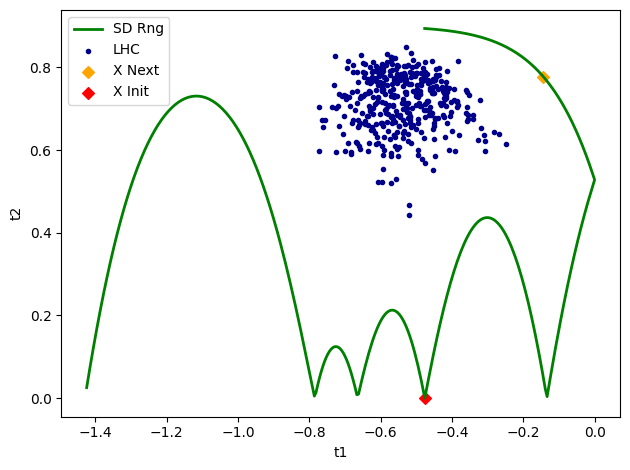

In [44]:
acq_data.plot_t1_t2(6)

In [45]:
#acq_data.plot_t1_t2(7)

In [46]:
#acq_data.plot_t1_t2(8)

In [47]:
#acq_data.plot_t1_t2(9)

In [48]:
#acq_data.plot_t1_t2(10)

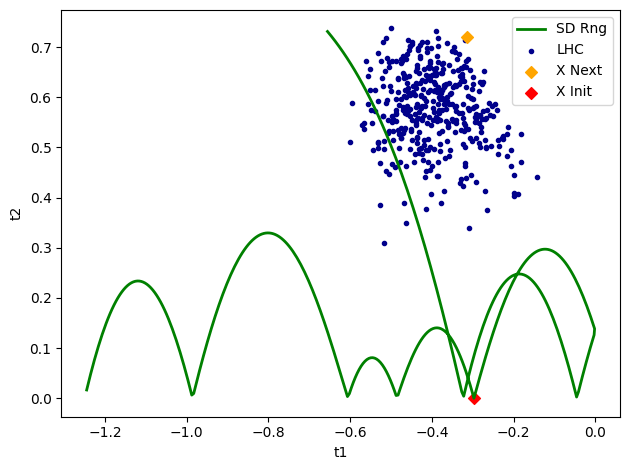

In [49]:
acq_data.plot_t1_t2(11)

In [50]:
#acq_data.plot_t1_t2(12)

In [51]:
#acq_data.plot_t1_t2(13)

In [52]:
#acq_data.plot_t1_t2(14)

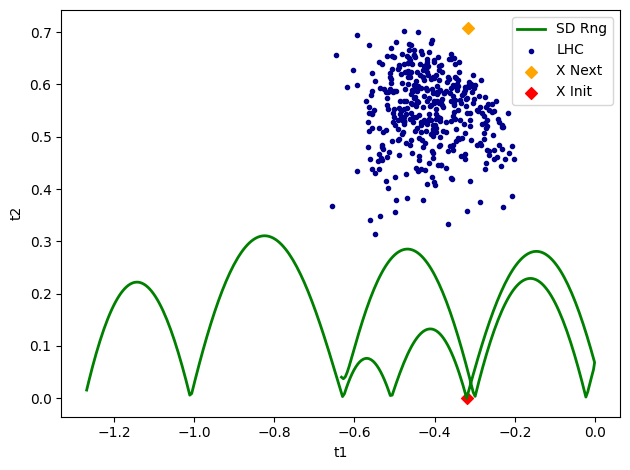

In [53]:
acq_data.plot_t1_t2(15)

In [54]:
#acq_data.plot_t1_t2(16)

In [55]:
#acq_data.plot_t1_t2(17)

In [56]:
#acq_data.plot_t1_t2(18)

In [57]:
#acq_data.plot_t1_t2(19)

Average, SD, and Max Differences:
y - BB(x):           50.99483274247781  :  25.886260008888392  :  78.61532954272607
y - exp(x):          50.99483273692671  :  25.886260010913492  :  78.61532954294756
BB(x) - exp(x):      6.819938391799951e-09  :  6.783613470746256e-09  :  1.8961856085297768e-08
Average exp(x) Uncertainty:  1.0000000413701846e-05
R Score:   1.0
Fidelity:  0.5670597433837292


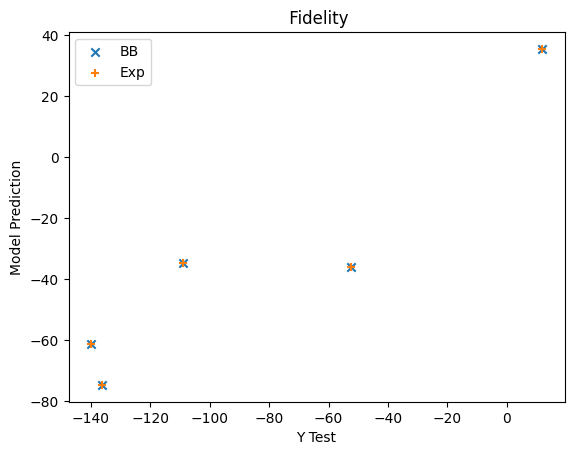

Fidelity:  0.5670597433837292


In [58]:
Reg_Stats.Fidelity()

print('Fidelity: ', Reg_Stats.fidelity)

In [59]:
Reg_Stats.Jaccard_Values(top_k=4)

print('Jaccard: ', Reg_Stats.jaccard_similarities)

Mean Jaccard Similarity:  0.5599999999999999
Mean Jaccard Distance:    0.44000000000000006
Jaccard:  0.5599999999999999


In [60]:
Reg_Stats.add_Feature_Coeffs(Feature_Coeffs = Reg_Data.get_Feature_Coeffs())
        
print('Coeff Ratio: ', Reg_Stats.coeffs_ratio)

Mean Coeffs Ratio:  [  0.           0.           5.09786725 -14.26934442  -5.84115727
   5.27514417  17.4434448   -1.73759872]
Mean Coeffs Error:  6.458069580400269
Coeff Ratio:  [  0.           0.           5.09786725 -14.26934442  -5.84115727
   5.27514417  17.4434448   -1.73759872]


In [61]:
delete_1_var = Reg_Stats.delete_one()

print('Delete 1 Variance: ', delete_1_var)

mean_variance [1991.65360699 2314.34844315  996.63400914 2324.41096781 1841.61557094
 2303.97471427 2371.29676532 1305.19177096]
Mean scores: [1991.65360699 2314.34844315  996.63400914 2324.41096781 1841.61557094
 2303.97471427 2371.29676532 1305.19177096]
sort_order [6 3 1 4 0 2 7 5]
sorted_scores [0.39450255 0.65176119 0.6521372  0.78624029 0.86099637 1.13600987
 1.33182833 2.1865242 ]
sorted_variance [1.22792541 1.2036466  1.19843593 0.95364131 1.0313353  0.51608564
 0.67586569 1.19306412]
Prediction Variance Feature Deletion: [1991.65360699 2314.34844315  996.63400914 2324.41096781 1841.61557094
 2303.97471427 2371.29676532 1305.19177096]
Delete One Incoherence: 0.5673367363680224
Delete 1 Variance:  None


N_Points:  25


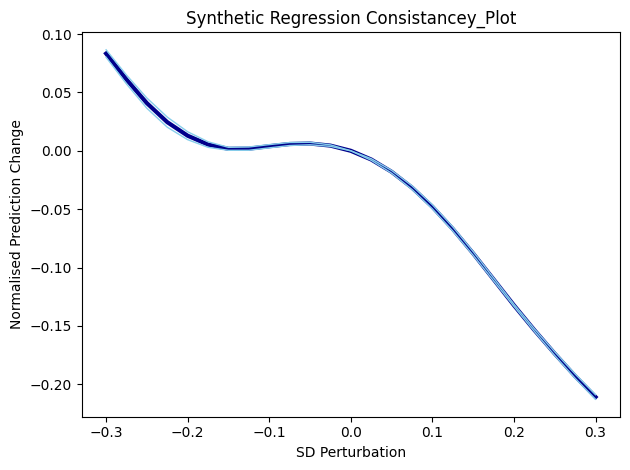

In [62]:
Reg_Stats.Consistancy(std_bound = consist_bound, plot=True, title = Title)

In [63]:
Reg_Stats.Compare_Models (model_b = Reg_Stats_2)

Score Diff Mean:  [0.89443737 0.64221597 1.34696791 0.63596673 0.768659   1.91625426
 0.22798372 1.56751504]
Score Diff SD:    [0.35964248 0.37834847 1.05757881 0.61649477 0.29648967 1.80509053
 0.29222142 0.73657507]


Calibration MSE/MAE 0.918517234940977 0.7425842175902077


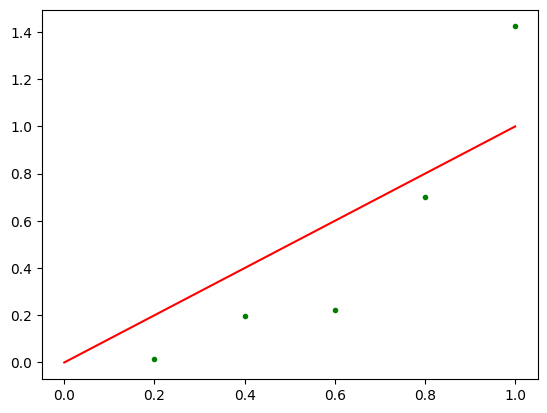

In [64]:
Reg_Stats.Regression_Calibration(plot=True, title=Title)

In [65]:
print(Reg_Stats.calibration_MAE)

0.7425842175902077


In [66]:
Reg_Stats.delete_one()

mean_variance [1991.65360699 2314.34844315  996.63400914 2324.41096781 1841.61557094
 2303.97471427 2371.29676532 1305.19177096]
Mean scores: [1991.65360699 2314.34844315  996.63400914 2324.41096781 1841.61557094
 2303.97471427 2371.29676532 1305.19177096]
sort_order [6 3 1 4 0 2 7 5]
sorted_scores [0.39450255 0.65176119 0.6521372  0.78624029 0.86099637 1.13600987
 1.33182833 2.1865242 ]
sorted_variance [1.22792541 1.2036466  1.19843593 0.95364131 1.0313353  0.51608564
 0.67586569 1.19306412]
Prediction Variance Feature Deletion: [1991.65360699 2314.34844315  996.63400914 2324.41096781 1841.61557094
 2303.97471427 2371.29676532 1305.19177096]
Delete One Incoherence: 0.5673367363680224


In [67]:
Reg_Stats.Results_Summary(Title)

Results_Summary: Synthetic Regression
R Score:   1.0
Fidelity:  0.5670597433837292
Consistancey Std/Y Pert:  0.3 : -0.06378092818681919
Delete One Incoherence:   0.5673367363680224
Mean Jaccard Similarity:  0.5599999999999999
Mean Jaccard Distance:    0.44000000000000006
Calibration MSE/MAE:  0.918517234940977 : 0.7425842175902077
Score Diff Mean:  [0.89443737 0.64221597 1.34696791 0.63596673 0.768659   1.91625426
 0.22798372 1.56751504]
Score Diff SD:    [0.35964248 0.37834847 1.05757881 0.61649477 0.29648967 1.80509053
 0.29222142 0.73657507]
Mean Coeffs Error:  6.458069580400269
